# Neural Style transfer using TensorFlow

## Import and configure modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

     |████████████████████████████████| 348.9MB 80kB/s 
     |████████████████████████████████| 3.1MB 37.0MB/s 
     |████████████████████████████████| 501kB 38.7MB/s 


## Getting the Content and Style Images Path

In [0]:
content_path="/content/IMG_1470.JPG"
style_path="/content/style.jpg"

# Visualize the input

## Define a function to load an image and limit its maximum dimension to 512 pixels.

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


**Create a simple function to display an image**

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

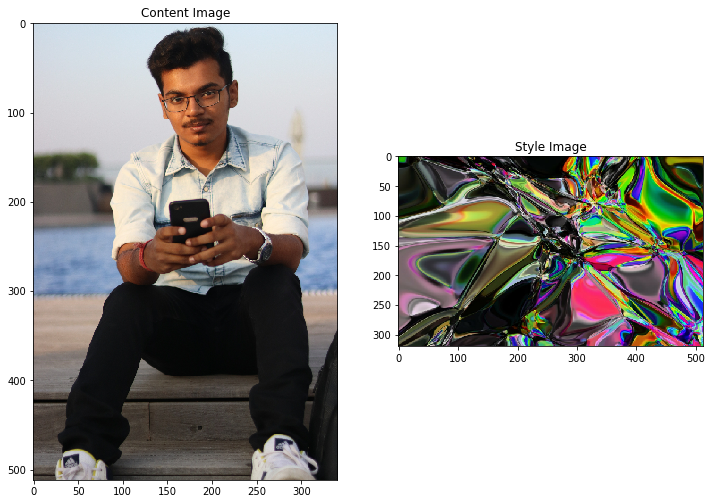

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Define content and style representations

**Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.**

##Load a VGG19 and test run it on our image to ensure it's used correctly:

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 18s 0us/step


TensorShape([1, 1000])

In [7]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('bow_tie', 0.04581453),
 ('tricycle', 0.042081244),
 ('running_shoe', 0.039878026),
 ('soccer_ball', 0.033189137),
 ('dalmatian', 0.032213498)]

### Now load a VGG19 without the classification head, and list the layer names

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 3s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Choose intermediate layers from the network to represent the style and content of the image

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Build the model

### The networks in tf.keras.applications are designed so you can easily extract the intermediate layer values using the Keras functional API.

## To define a model using the functional API, specify the inputs and outputs:


> ###        model = Model(inputs, outputs)




## This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [0]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

## And to create the model:

In [11]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 320, 512, 64)
  min:  0.0
  max:  783.72577
  mean:  28.595703

block2_conv1
  shape:  (1, 160, 256, 128)
  min:  0.0
  max:  7035.747
  mean:  174.48546

block3_conv1
  shape:  (1, 80, 128, 256)
  min:  0.0
  max:  15250.074
  mean:  236.42802

block4_conv1
  shape:  (1, 40, 64, 512)
  min:  0.0
  max:  28027.293
  mean:  769.996

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  3436.588
  mean:  62.951935



## Calculate style

### he content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer

### This can be implemented concisely using the "tf.linalg.einsum" function:

In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content

Build a model that returns the style and content tensors.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


## When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [14]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.026819648
    max:  40073.113
    mean:  426.31433

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  57479.742
    mean:  12750.23

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.038968835
    max:  207308.8
    mean:  13108.672

   block4_conv1
    shape:  (1, 512, 512)
    min:  5.2606044
    max:  2773814.5
    mean:  194806.61

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  156766.52
    mean:  2131.7366

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  2334.1887
    mean:  17.366972


## Run gradient descent

**Set your style and content target values:**

In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

### Define a tf.Variable to contain the image to optimize. To make this quick, initialize it with the content image (the tf.Variable must be the same shape as the content image):

In [0]:
image = tf.Variable(content_image)

### Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

### Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#To optimize this, use a weighted combination of the two losses to get the total loss
style_weight=1e-2
content_weight=1e4

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

### Use tf.GradientTape to update the image.

W0821 13:25:49.560035 139990202193792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


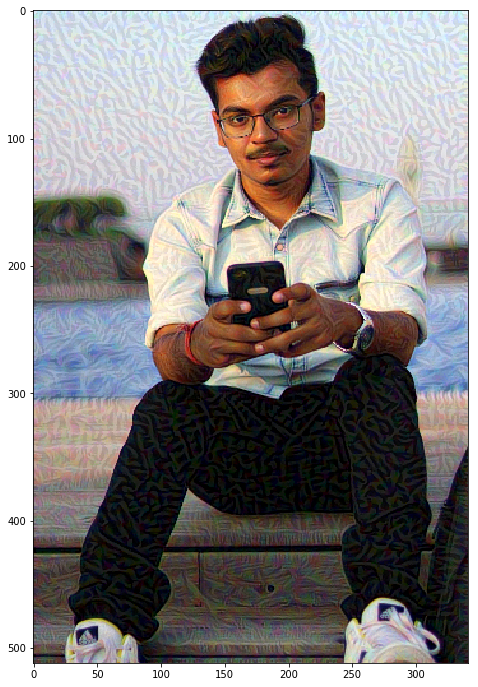

In [20]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#Now run a few steps to test
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

## Since it's working, perform a longer optimization:

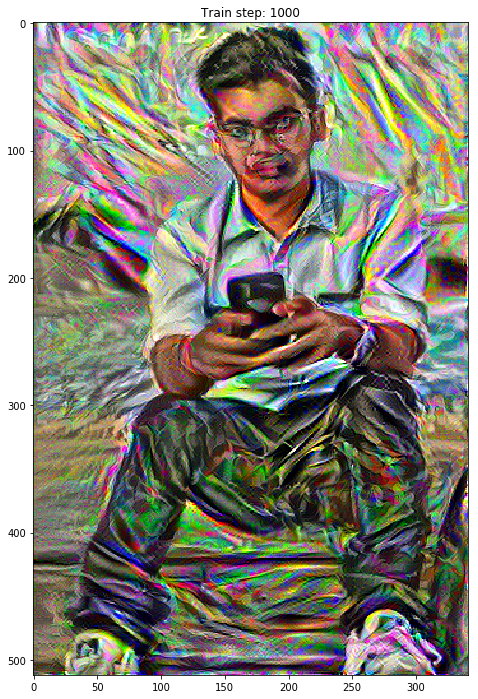

Total time: 174.6


In [21]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

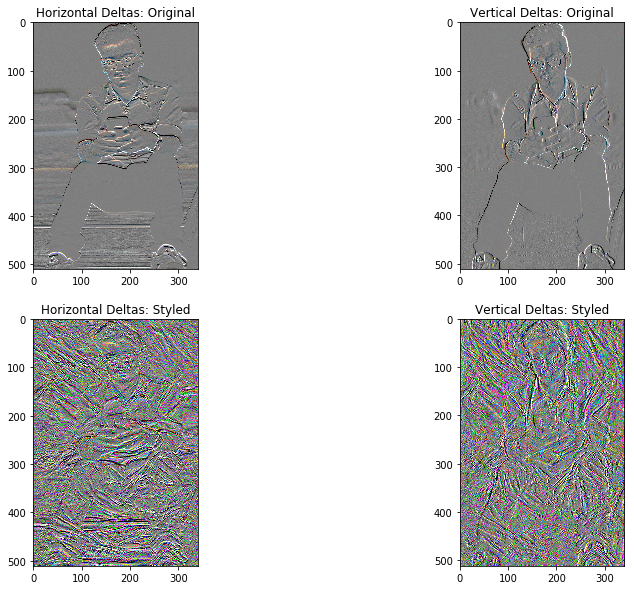

In [23]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

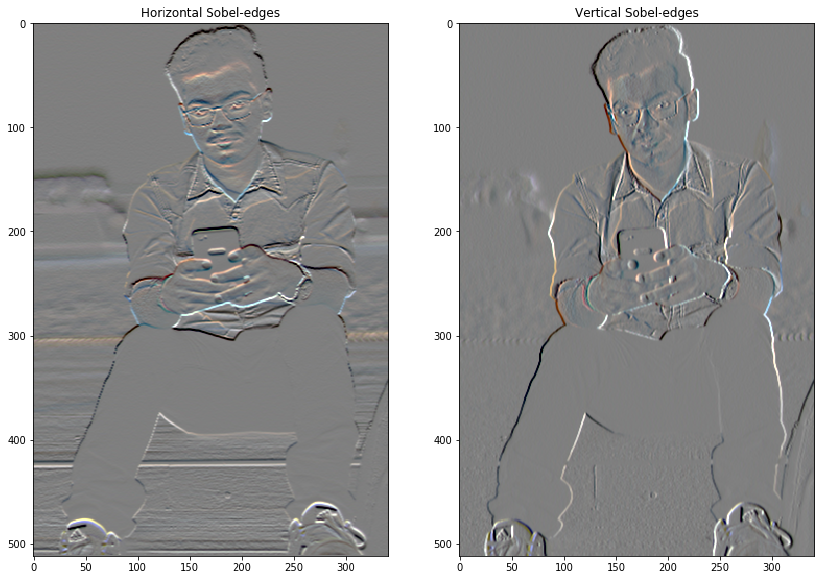

In [24]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

## The regularization loss asociated with this is the sum of the squares of the values:

In [0]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

## Re-run the optimization

Choose a weight for the total_variation_loss:

In [0]:
total_variation_weight=1e8

#Now include it in the "train_step" function:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#Re-initialise the optimization variable:

image = tf.Variable(content_image)

**And run the optimization:**

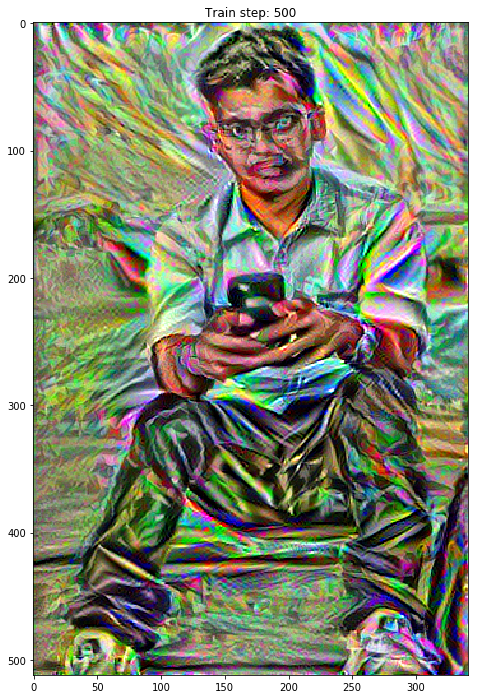

Total time: 93.1


In [27]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))


## Thus we have the styled image